#**• DOMAIN: Digital content and entertainment industry**

#**• PROJECT OBJECTIVE: Build a sequential NLP classifier which can use input text parameters to determine the customer sentiments.**

##**1. Import and analyse the data set.**

In [2]:
#for reading data from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import tensorflow as tf

from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score

import warnings
warnings.filterwarnings('ignore')

from keras.datasets import imdb

In [4]:
# LOAD IMDB DATA
most_freqWords=10000
(X_train_features,y_train_labels),(X_test_features,y_test_labels)=imdb.load_data(num_words=most_freqWords)

17473536/17464789 [==============================] - 0s 0us/step


In [5]:
print("Training Features :",X_train_features.shape)
print("Training Labels :",y_train_labels.shape)

Training Features : (25000,)
Training Labels : (25000,)


In [6]:
print("Testing Features :",X_test_features.shape)
print("Testing Labels :",y_test_labels.shape)

Testing Features : (25000,)
Testing Labels : (25000,)


In [7]:
print("Maximum value of a word index")
print(max([max(sequence) for sequence in X_train_features]))
print("Maximum length num words of review in train")
print(max([len(sequence) for sequence in X_train_features]))

Maximum value of a word index
9999
Maximum length num words of review in train
2494


#**2. Perform relevant sequence adding on the data**

###We need to encode the sequences into a binary matrix so that they are all the same length of modelling. This is basically called as one hot encoder. We are converting the integer representing words at various lengths to a normalized one hot encode tensor(matrix) of 10k columns.###

In [8]:
# VECTORIZE as one cannot feed integers into a NN 
# Encoding the integer sequences into a binary matrix - one hot encoder basically
# From integers representing words, at various lengths - to a normalized one hot encoded tensor (matrix) of 10k columns
def vectorize_sequences(sequences,dimension=10000):
    results=np.zeros((len(sequences),dimension))
    for i,sequence in enumerate(sequences):
        results[i,sequence]=1
        return results

In [9]:
#Vectorize the Features
X_train=vectorize_sequences(X_train_features)
X_test=vectorize_sequences(X_test_features)

In [10]:
# VECTORIZE the labels too - NO INTEGERS only floats into a tensor...(rare exceptions)
#Vectorize the Labels(Float into tensor)
y_train=np.asarray(y_train_labels).astype('float32')
y_test=np.asarray(y_test_labels).astype('float32')

###**3. Perform following data analysis:**

####**• Print shape of features and labels • Print value of any one feature and it's label**

In [11]:
print("Shape of features for training and testing")
print("X_train :",X_train.shape)
print("X_test :",X_test.shape)

Shape of features for training and testing
X_train : (25000, 10000)
X_test : (25000, 10000)


In [12]:
print("Shape of labels for training and testing")
print("y_train :",y_train.shape)
print("y_test :",y_test.shape)

Shape of labels for training and testing
y_train : (25000,)
y_test : (25000,)


In [13]:
print("One feature and its label for training :")
print("Value of one feature :",X_train[0])
print("Value of one label :",y_train[0])

One feature and its label for training :
Value of one feature : [0. 1. 1. ... 0. 0. 0.]
Value of one label : 1.0


In [14]:
print("One feature and its label for testing :")
print("Value of one feature :",X_test[0])
print("Value of one label :",y_test[0])

One feature and its label for testing :
Value of one feature : [0. 1. 1. ... 0. 0. 0.]
Value of one label : 0.0


In [15]:
# Set a VALIDATION set
X_val=X_train[:10000]
partial_X_train=X_train[10000:]
y_val=y_train[:10000]
partial_y_train=y_train[10000:]

print("X_val :",X_val.shape)
print("Partial_X_train :",partial_X_train.shape)
print("y_val :",y_val.shape)
print("Partial_y_train :",partial_y_train.shape)


X_val : (10000, 10000)
Partial_X_train : (15000, 10000)
y_val : (10000,)
Partial_y_train : (15000,)


###**4. Decode the feature value to get original sentence**

In [16]:
# See an actual review in words
# Reverse from integers to words using the DICTIONARY (given by keras...need to do nothing to create it)

word_index=imdb.get_word_index()
reverse_word_index=dict([(value,key) for (key,value) in word_index.items()])
decoded_review=' '.join([reverse_word_index.get(i-3,'?') for i in X_train_features[123]])
print(decoded_review)

1654784/1641221 [==============================] - 0s 0us/step
? beautiful and touching movie rich colors great settings good acting and one of the most charming movies i have seen in a while i never saw such an interesting setting when i was in china my wife liked it so much she asked me to ? on and rate it so other would enjoy too


###**5. Design, train, tune and test a sequential model.**

In [17]:
# model parameters
vocab_size=len(word_index)+1
embedding_dim=100
max_length=10000
trunc_type='post'
padding_type='post'
oov_tok='<OOV>'

model=tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
      tf.keras.layers.GlobalAveragePooling1D(),
      tf.keras.layers.Dense(24,activation='relu'),
      tf.keras.layers.Dense(1,activation='sigmoid')          
])

In [18]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10000, 100)        8858500   
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                2424      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,860,949
Trainable params: 8,860,949
Non-trainable params: 0
_________________________________________________________________


In [20]:
#fit the model
history=model.fit(partial_X_train,partial_y_train,epochs=3,verbose=2,validation_data=(X_val, y_val))

Epoch 1/3
469/469 - 129s - loss: 0.6933 - accuracy: 0.5034 - val_loss: 0.6936 - val_accuracy: 0.4947 - 129s/epoch - 275ms/step
Epoch 2/3
469/469 - 121s - loss: 0.6933 - accuracy: 0.4983 - val_loss: 0.6934 - val_accuracy: 0.4947 - 121s/epoch - 259ms/step
Epoch 3/3
469/469 - 108s - loss: 0.6932 - accuracy: 0.4986 - val_loss: 0.6932 - val_accuracy: 0.4947 - 108s/epoch - 230ms/step


In [21]:
# predict values
y_pred=model.predict(X_test)

In [22]:
print("Accuracy of the model on Training Data :",model.evaluate(X_train,y_train)[1])
print("Accuracy of the model on Testing Data :",model.evaluate(X_test,y_test)[1])

782/782 [==============================] - 42s 54ms/step - loss: 0.6931 - accuracy: 0.5000
Accuracy of the model on Training Data : 0.5
782/782 [==============================] - 43s 55ms/step - loss: 0.6931 - accuracy: 0.5000
Accuracy of the model on Testing Data : 0.5


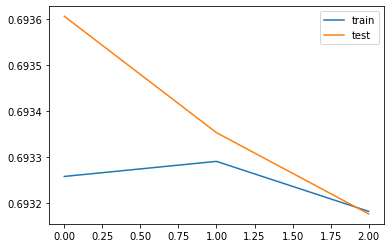

In [23]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

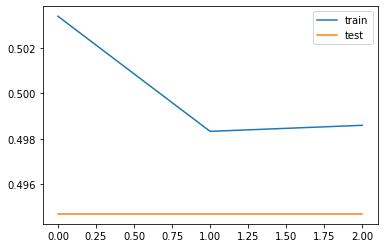

In [24]:
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.show()

###**6. Use the designed model to print the prediction on any one sample.**



In [30]:
i=123
test_pred=model.predict(np.array(X_test[:32*10]),verbose=1)
idx2tag={i: w for w, i in word_index.items()}

def pred2label(pred):
    out=[]
    for pred_i in pred:
        out_i=[]
        for p in pred_i:
            p_i=np.argmax(p)
            out_i.append(idx2tag[p_i])
            out.append(out_i)
    return out

10/10 [==============================] - 1s 70ms/step


#**• DOMAIN: Social media analytics**

##**• PROJECT OBJECTIVE: Build a sequential NLP classifier which can use input text parameters to determine the customer sentiments.**

###**1. Read and explore the data**

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import string
from string import punctuation

from wordcloud import WordCloud

import re
import bs4
from bs4 import BeautifulSoup
import gensim

import nltk
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn import preprocessing
from keras.preprocessing import text,sequence

from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU,Input,TimeDistributed
from keras.models import Model

from keras.callbacks import EarlyStopping,ReduceLROnPlateau

from sklearn import metrics
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score,confusion_matrix

#surpress display of warning
import warnings
warnings.filterwarnings('ignore')

In [32]:
df_sarc=pd.read_json('/content/drive/My Drive/AIML/NLP/Project2_Data/Sarcasm_Headlines_Dataset.json',lines=True)
df_sarc.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [33]:
print("No. of Rows and Columns in dataframe")
df_sarc.shape

No. of Rows and Columns in dataframe


(26709, 3)

In [34]:
print("No. of elements in dataframe")
df_sarc.size

No. of elements in dataframe


80127

In [35]:
df_sarc.columns

Index(['article_link', 'headline', 'is_sarcastic'], dtype='object')

In [36]:
df_sarc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [37]:
df_sarc.isna().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

No null value in the dataset


In [38]:
df_sarc['headline'].describe()

count              26709
unique             26602
top       sunday roundup
freq                  10
Name: headline, dtype: object

###**Exploratory Data Analysis**

In [39]:
print("0-Non Sarcastic Comment, ","1-Sacrastic Comment")
df_sarc.is_sarcastic.value_counts()

0-Non Sarcastic Comment,  1-Sacrastic Comment


0    14985
1    11724
Name: is_sarcastic, dtype: int64

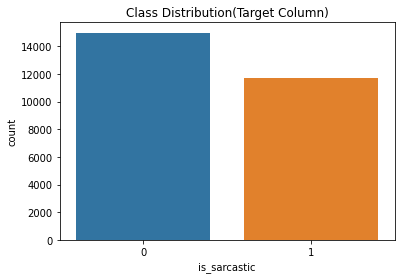

In [40]:
plt.figure()
sns.countplot(data=df_sarc,x='is_sarcastic')
plt.title("Class Distribution(Target Column)")
plt.show()

Above graph shows the slightly imbalanced data

In [41]:
df_sarc['website']=df_sarc.article_link.apply(lambda x: x.split('/')[2])
df_sarc.head()

,article_link,headline,is_sarcastic,website
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,www.huffingtonpost.com
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,www.huffingtonpost.com
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,local.theonion.com
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,politics.theonion.com
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,www.huffingtonpost.com


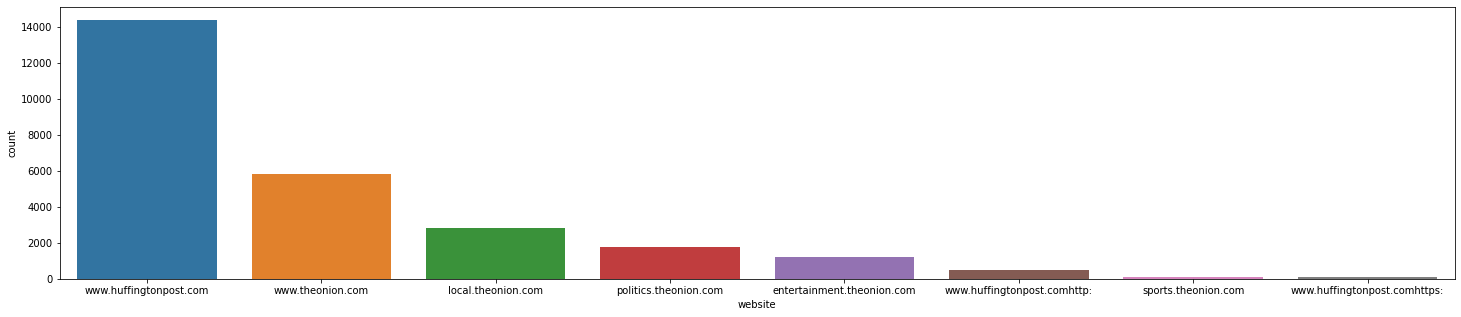

In [42]:
plt.figure(figsize=(25,5))
sns.countplot(data=df_sarc,x=df_sarc.website,order=df_sarc['website'].value_counts().index)

Text(0.5, 1.0, 'Non-Sarcastic Text')

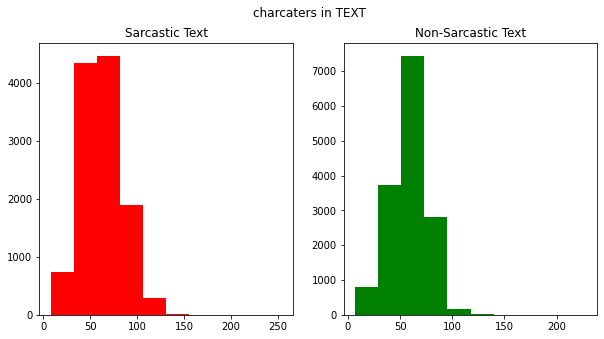

In [43]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
fig.suptitle("charcaters in TEXT")

text_len=df_sarc[df_sarc['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic Text')

text_len=df_sarc[df_sarc['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Non-Sarcastic Text')

Text(0.5, 1.0, 'Non-Sarcastic Text')

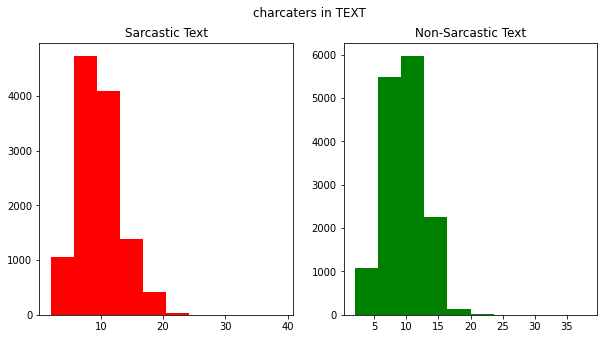

In [44]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
fig.suptitle("charcaters in TEXT")

text_len=df_sarc[df_sarc['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic Text')

text_len=df_sarc[df_sarc['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Non-Sarcastic Text')

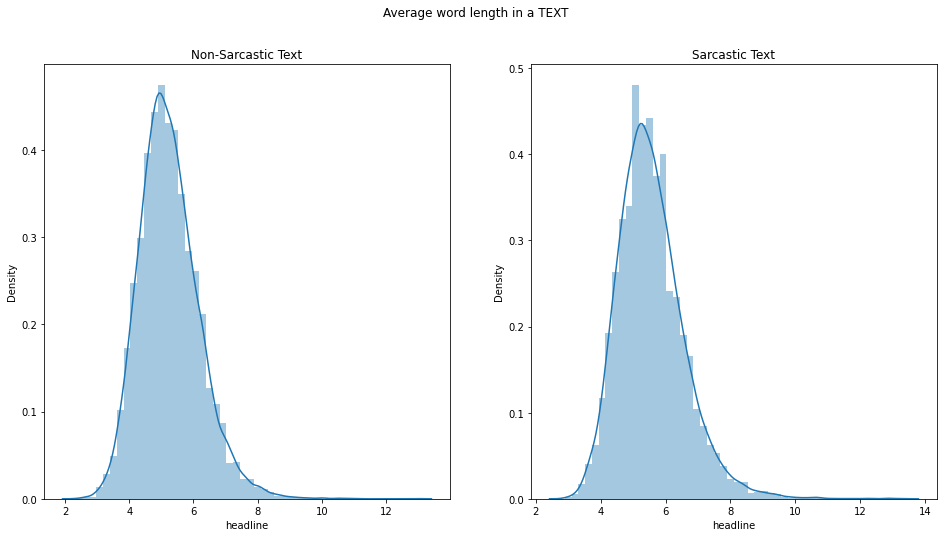

In [45]:
fig,ax=plt.subplots(figsize=(16,8))
fig.suptitle("Average word length in a TEXT")

plt.subplot(1,2,1)
plt.title('Non-Sarcastic Text')
word_length=df_sarc[df_sarc['is_sarcastic']==0]['headline'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word_length.map(lambda x:np.mean(x)),kde=True)

plt.subplot(1,2,2)
plt.title('Sarcastic Text')
word_length=df_sarc[df_sarc['is_sarcastic']==1]['headline'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word_length.map(lambda x:np.mean(x)),kde=True)

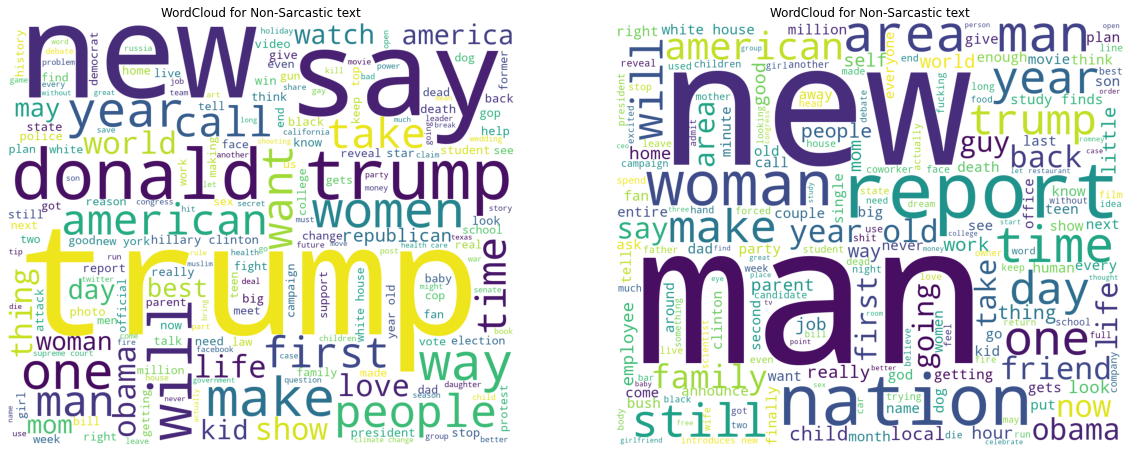

In [46]:
fig,ax=plt.subplots(figsize=(20,15))
plt.axis("off")

plt.subplot(1,2,1)
text=" ".join(df_sarc[df_sarc['is_sarcastic']==0]['headline'])
wordcloud=WordCloud(max_font_size=None,background_color='white',width=1200,height=1000).generate(text)
plt.title("WordCloud for Non-Sarcastic text")
plt.axis('off')
plt.imshow(wordcloud)

plt.subplot(1,2,2)
text=" ".join(df_sarc[df_sarc['is_sarcastic']==1]['headline'])
wordcloud=WordCloud(max_font_size=None,background_color='white',width=1200,height=1000).generate(text)
plt.title("WordCloud for Non-Sarcastic text")
plt.axis('off')
plt.imshow(wordcloud)


###**Data Processing(Cleaning)**

In [47]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [48]:
stop=set(stopwords.words('english'))
punctuation=list(string.punctuation)
stop.update(punctuation)

In [49]:
def strip_html(text):
    soup=BeautifulSoup(text,"html.parser")
    return soup.get_text()

def remove_squarebrackets(text):
    return re.sub('\[[^]]*\]', '',text) 

def remove_urls(text):
    return re.sub(r'http\S+', '',text)

def remove_stopwords(text):
    final_text=[]
    for i in text.split():
        if i.strip().lower() not in stop:
           final_text.append(i.strip())
    return " ".join(final_text)

def remove_noisytext(text):
    text=strip_html(text)
    text=remove_squarebrackets(text)
    text=remove_urls(text)
    text=remove_stopwords(text)
    return text

df_sarc['headline']=df_sarc['headline'].apply(remove_noisytext)

In [51]:
df_sarc.head()

,article_link,headline,is_sarcastic,website
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues secret 'black ...,0,www.huffingtonpost.com
1,https://www.huffingtonpost.com/entry/roseanne-...,'roseanne' revival catches thorny political mo...,0,www.huffingtonpost.com
2,https://local.theonion.com/mom-starting-to-fea...,mom starting fear son's web series closest thi...,1,local.theonion.com
3,https://politics.theonion.com/boehner-just-wan...,"boehner wants wife listen, come alternative de...",1,politics.theonion.com
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday magic...,0,www.huffingtonpost.com


###**2. Retain relevant columns**

We need only the text(headline) and target column(is_sarcastic). So, we are deleting 'article_link' column as it is of no use and we are only intersted in 'headline' and 'is_sarcastic'. 

In [52]:
df_sarc=df_sarc.drop(['article_link','website'],axis=1)

In [53]:
df_sarc.head()

,headline,is_sarcastic
0,former versace store clerk sues secret 'black ...,0
1,'roseanne' revival catches thorny political mo...,0
2,mom starting fear son's web series closest thi...,1
3,"boehner wants wife listen, come alternative de...",1
4,j.k. rowling wishes snape happy birthday magic...,0


###**3. Get length of each sentence**

In [54]:
def length(phrase):
  return len(phrase.split())

In [55]:
df_sarc['length']=df_sarc['headline'].apply(length)
df_sarc.head()

,headline,is_sarcastic,length
0,former versace store clerk sues secret 'black ...,0,10
1,'roseanne' revival catches thorny political mo...,0,8
2,mom starting fear son's web series closest thi...,1,9
3,"boehner wants wife listen, come alternative de...",1,8
4,j.k. rowling wishes snape happy birthday magic...,0,8


###**4. Define parameters**

In [56]:
#We will use these parameters for later use
pad_type='post'
trunc_type='post'
max_word=20000 #We will train our model with only top 2000 common words
max_len=200

batch_size=50
epoch=5

oov_tok="<OOV>"
embedding_dim=200  #Dimension of vectors we are generating
window=5
mincount=1
dropout_rate=0.30

test_size=0.20
rand_state=42

###**5. Get indices for words**

In [57]:
tokenizer=Tokenizer(num_words=max_word,oov_token=oov_tok,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ',char_level=False)
tokenizer.fit_on_texts(df_sarc['headline'])

In [58]:
word_index=tokenizer.word_index
len(word_index)

29590

In [59]:
word_counts=tokenizer.word_counts
len(word_counts)

29589

###**6. Create features and labels**

In [60]:
# label_encoder object knows how to understand word labels. 
label_encoder=preprocessing.LabelEncoder()

# Encode labels in column 'class'. 
df_sarc['is_sarcastic']=label_encoder.fit_transform(df_sarc['is_sarcastic'])

In [61]:
X=df_sarc['headline']
y=df_sarc['is_sarcastic']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [62]:
tokenized_train=tokenizer.texts_to_sequences(X_train)
X_train=sequence.pad_sequences(tokenized_train,maxlen=300)

tokenized_test=tokenizer.texts_to_sequences(X_test)
X_test=sequence.pad_sequences(tokenized_test,maxlen=300)

In [63]:
print("Shape of data for training")
print(X_train.shape,y_train.shape)
print("Shape of data for testing")
print(X_test.shape,y_test.shape)

Shape of data for training
(18696, 300) (18696,)
Shape of data for testing
(8013, 300) (8013,)


###**7. Get vocabulary size**

Vocabulary size will be the total number of the words in the word_index identified by the tokenizer from the training data.


In [64]:
vocab_size=len(tokenizer.word_index)
print("Vocabulary Size:",vocab_size)

Vocabulary Size: 29590


###**8. Create a weight matrix using GloVe embeddings**

In [65]:
Embedding_File="/content/drive/My Drive/AIML/NLP/Project2_Data/DataSet - glove.6B.50d.txt"

In [66]:
embeddings_index=dict()
f=open(Embedding_File)
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:],dtype='float32')
    embeddings_index[word]=coefs
f.close()
print('Loaded %s word vectors' % len(embeddings_index))

Loaded 400000 word vectors


In [67]:
#Creating weight matrix for words in training docs

weight_matrix=np.zeros((vocab_size+1,50))
for word,i in tokenizer.word_index.items():
    embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None:
       weight_matrix[i]=embedding_vector

In [68]:
weight_matrix.shape

(29591, 50)

###**9. Define and compile a Bidirectional LSTM model.**

In [69]:
batch_size=256
epochs=5
embed_size=50
maxlen=300
max_features=29591

#Defining neural network with bidirectional LSTM model
model=Sequential()
model.add(Embedding(max_features,output_dim=embed_size,weights=[weight_matrix],input_length=maxlen,trainable=True))
model.add(LSTM(units=128,return_sequences=True,recurrent_dropout=0.4,dropout=0.4))
model.add(GRU(units=256,return_sequences=False,dropout=0.4))
model.add(Dense(3,activation='softmax'))

In [70]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])

In [71]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 50)           1479550   
                                                                 
 lstm (LSTM)                 (None, 300, 128)          91648     
                                                                 
 gru (GRU)                   (None, 256)               296448    
                                                                 
 dense_2 (Dense)             (None, 3)                 771       
                                                                 
Total params: 1,868,417
Trainable params: 1,868,417
Non-trainable params: 0
_________________________________________________________________


###**10. Fit the model and check the validation accuracy**

In [72]:
#Callbacks
earlystop=EarlyStopping(monitor='val_loss',patience=1,verbose=1)
learning_reduce=ReduceLROnPlateau(patience=1,monitor='val_acc',verbose=1,min_lr=0.00001,factor=0.5,cooldown=1)
callbacks=[earlystop,learning_reduce]

In [73]:
history=model.fit(X_train,y_train,epochs=2,validation_data=(X_test,y_test),callbacks=callbacks)

Epoch 1/2
585/585 [==============================] - 1196s 2s/step - loss: 0.5750 - acc: 0.6996 - val_loss: 0.4771 - val_acc: 0.7731 - lr: 0.0010
Epoch 2/2
585/585 [==============================] - 1078s 2s/step - loss: 0.4442 - acc: 0.7909 - val_loss: 0.4171 - val_acc: 0.8022 - lr: 0.0010


In [74]:
print("Accuracy of the model on Training Data :",model.evaluate(X_train,y_train)[1])
print("Accuracy of the model on Testing Data :",model.evaluate(X_test,y_test)[1])

585/585 [==============================] - 204s 348ms/step - loss: 0.3230 - acc: 0.8592
Accuracy of the model on Training Data : 0.859167754650116
251/251 [==============================] - 87s 346ms/step - loss: 0.4171 - acc: 0.8022
Accuracy of the model on Testing Data : 0.8021964430809021
